# Coding for Economists 2025 — Diamonds Project
**Autor:** _Ludovica_Capelli_  
**Date:** 2025-11-09

This jupyter notebook demonstrate the accomplishment of the 15 Learning Outcomes with the dataset `diamonds.csv`.



In [29]:
# Loading the moduls used in the analysis

from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from plotnine import ggplot, aes, geom_point, geom_histogram, geom_boxplot, geom_bar, facet_wrap, labs, theme_bw, geom_smooth
from skimpy import skim

# 1. Set up and directories structure

In [3]:
# Setting the different paths of the project

CURRENT_DIR = Path.cwd().resolve()

DATA = CURRENT_DIR / "data" 
RAW_DATA = DATA / "raw"
CLEAN_DATA = DATA / "clean"
DATA_OUTPUT = CURRENT_DIR / "output"
FIGURES = DATA_OUTPUT / "figures"
TABLES = DATA_OUTPUT / "tables"

In [4]:
# Creation of the directories that do not exists

for i in [DATA, RAW_DATA, CLEAN_DATA, DATA_OUTPUT, FIGURES, TABLES]:
    i.mkdir(parents = True, exist_ok = True)
    

In [5]:
# Ordering the directories candidated for the CSV in order of preference

dir_candidates = [
    DATA / "diamonds.csv",    
    RAW_DATA / "diamonds.csv", 
    CURRENT_DIR / "diamonds.csv"
]

# Selection of the first path 
csv_path = next((p for p in dir_candidates if p.exists()), None)

In [6]:
# Testing the current path of the directories

print ("Project directories:")
for c in [DATA, RAW_DATA, CLEAN_DATA, DATA_OUTPUT, FIGURES, TABLES]:
    print(" -", c)

print (" \nCSV research")    
if csv_path is None:
    raise FileNotFoundError(
        "diamonds.csv not found. Include the file in one of this paths:\n"
        f" - {dir_candidates[0]}\n - {dir_candidates[1]}\n - {dir_candidates[2]}"
    )
else: 
    print( "diamonds.csv found", csv_path)

Project directories:
 - /Users/ludish/Desktop/Coding-for-economist-assignment-2025/data
 - /Users/ludish/Desktop/Coding-for-economist-assignment-2025/data/raw
 - /Users/ludish/Desktop/Coding-for-economist-assignment-2025/data/clean
 - /Users/ludish/Desktop/Coding-for-economist-assignment-2025/output
 - /Users/ludish/Desktop/Coding-for-economist-assignment-2025/output/figures
 - /Users/ludish/Desktop/Coding-for-economist-assignment-2025/output/tables
 
CSV research
diamonds.csv found /Users/ludish/Desktop/Coding-for-economist-assignment-2025/data/raw/diamonds.csv


# 2. Read CSV and filtering the dataset

In [ ]:
# Loading the dataset from a CSV into a Dataframe

df = pd.read_csv(csv_path)

In [ ]:
# Manipulation of the columns to eliminate sapces and to convert the variables names into lower-case letters

df.columns = [c.strip().lower() for c in df.columns]

# For loop to check if the columns values are numeric or not

for columns in ["price", "carat", "depth", "table", "x","y", "z"]:
    if columns in df.columns:
        df[columns]=pd.to_numeric(df[columns], errors = "coerce")

# Removing eventually unnamed columns (frequent in pandas)

df= df.loc[:, ~df.columns.str.contains('^unnamed')]

# Check of the first rows of the dataset to check the cleaning process

print(df.head())

# Removing from the dataframe eventually missing values or negative values that are not reasonable for the variables price and carat. In the end it will compare the initial length of the dataframe with the resulted one from the cleaning process

with_negative_values = len(df)
df = df.dropna(subset=["price", "carat"])
df = df[(df["price"]>0) & df["carat"]>0]
without_negative_values = len(df)

print(with_negative_values, without_negative_values)

   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
53940 53940


# 3. creation of list and dictionaries

In [11]:
# Creation of a list to specify which columns to keep in the dataframe

columns_to_keep = ["price", "carat", "cut", "color", "clarity", "depth", "table"]

# Assign a score to each category of the variable cut

cut_score_labels = {
    "Fair" : 1, 
    "Good" : 2, 
    "Very Good": 3,
    "Premium" : 4,
    "Ideal" : 5
}

# Creation of a new column that is empty

df["cut_score"]=np.nan

# Creation of a loop cycle to assign a score to each cut category

for labels, score in cut_score_labels.items():
    df.loc[df["cut"]== labels, "cut_score"]=score

print(df[["cut", "cut_score"]].head(10))

print(df.iloc[:5, :11])

         cut  cut_score
0      Ideal        5.0
1    Premium        4.0
2       Good        2.0
3    Premium        4.0
4       Good        2.0
5  Very Good        3.0
6  Very Good        3.0
7  Very Good        3.0
8       Fair        1.0
9  Very Good        3.0
   carat      cut color clarity  depth  table  price     x     y     z  \
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43   
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31   
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31   
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63   
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75   

   cut_score  
0        5.0  
1        4.0  
2        2.0  
3        4.0  
4        2.0  


# 4. Data manipulation and filtering

In [12]:
# Filtering the dataframe: mantaining in the dataframe only the values that have "carat" <= 3 and adding to the dataframe the variable created before (cut_score) and mantaining in the dataframe only the columns specified before (columns_to_keep)
# Creation of a copy of the dataframe to not overwrite the original one

df_small_carat = df.loc[df["carat"]<= 3, columns_to_keep + ["cut_score"]].copy()

# Definition of two new variables price_per_carat and ln_price

df_small_carat["price_per_carat"] = df_small_carat["price"]/df_small_carat["carat"]
df_small_carat["ln_price"] = np.log(df_small_carat["price"])

print (df_small_carat.head(10))

   price  carat        cut color clarity  depth  table  cut_score  \
0    326   0.23      Ideal     E     SI2   61.5   55.0        5.0   
1    326   0.21    Premium     E     SI1   59.8   61.0        4.0   
2    327   0.23       Good     E     VS1   56.9   65.0        2.0   
3    334   0.29    Premium     I     VS2   62.4   58.0        4.0   
4    335   0.31       Good     J     SI2   63.3   58.0        2.0   
5    336   0.24  Very Good     J    VVS2   62.8   57.0        3.0   
6    336   0.24  Very Good     I    VVS1   62.3   57.0        3.0   
7    337   0.26  Very Good     H     SI1   61.9   55.0        3.0   
8    337   0.22       Fair     E     VS2   65.1   61.0        1.0   
9    338   0.23  Very Good     H     VS1   59.4   61.0        3.0   

   price_per_carat  ln_price  
0      1417.391304  5.786897  
1      1552.380952  5.786897  
2      1421.739130  5.789960  
3      1151.724138  5.811141  
4      1080.645161  5.814131  
5      1400.000000  5.817111  
6      1400.000000  5.8

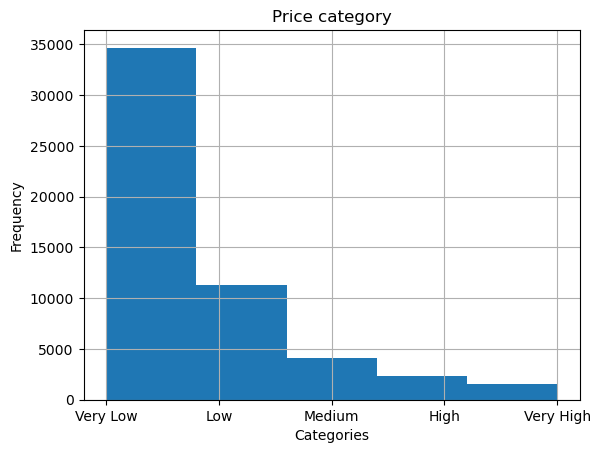

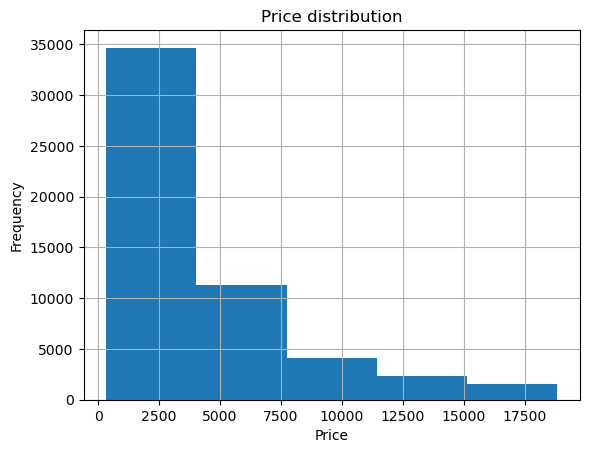

In [13]:
# Converting a numrical variable into a categorical one

df_small_carat["price_quantile"] = pd.qcut(df["price"], q=5)
df_small_carat["price_quantile"].value_counts()

# Assign the labels category

labels = ["Very Low", "Low", "Medium", "High", "Very High"]

# Dividing the variable price into categories through pd.cut
df_small_carat["price_category"] = pd.cut(df["price"], bins=5, labels=labels)

# Creation of two histograms to compare the price variable with the new categorical variable of price

df_small_carat["price_category"].hist(bins=5)
plt.title("Price category")
plt.xlabel("Categories")
plt.ylabel("Frequency")
plt.savefig(FIGURES/"histogram_price_category.png", bbox_inches="tight")


df_small_carat[["price"]].hist(bins=5)
plt.title("Price distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.savefig(FIGURES/"histogram_price.png", bbox_inches="tight")


In [ ]:
# Correcting a wrongly documented variable by changing the value from "J" to "S" through the function np.where

df_small_carat["color"].value_counts(dropna=False)
df_small_carat["color"] = np.where(df_small_carat["color"] == "J", "S", df_small_carat["color"])
df_small_carat["color"].value_counts(dropna=False)

color
G    11291
E     9796
F     9541
H     8298
D     6774
I     5409
S     2799
Name: count, dtype: int64

In [14]:
# Sorting all the dataframe by price to make it more readable

df_small_carat.sort_values(by=["price"], ascending=True)

,price,carat,cut,color,clarity,depth,table,cut_score,price_per_carat,ln_price,price_quantile,price_category
0,326,0.23,Ideal,E,SI2,61.5,55.0,5.0,1417.391304,5.786897,"(325.999, 837.0]",Very Low
1,326,0.21,Premium,E,SI1,59.8,61.0,4.0,1552.380952,5.786897,"(325.999, 837.0]",Very Low
2,327,0.23,Good,E,VS1,56.9,65.0,2.0,1421.739130,5.789960,"(325.999, 837.0]",Very Low
3,334,0.29,Premium,I,VS2,62.4,58.0,4.0,1151.724138,5.811141,"(325.999, 837.0]",Very Low
4,335,0.31,Good,J,SI2,63.3,58.0,2.0,1080.645161,5.814131,"(325.999, 837.0]",Very Low
...,...,...,...,...,...,...,...,...,...,...,...,...
27745,18803,2.00,Very Good,H,SI1,62.8,57.0,3.0,9401.500000,9.841772,"(6301.2, 18823.0]",Very High
27746,18804,2.07,Ideal,G,SI2,62.5,55.0,5.0,9084.057971,9.841825,"(6301.2, 18823.0]",Very High
27747,18806,1.51,Ideal,G,IF,61.7,55.0,5.0,12454.304636,9.841931,"(6301.2, 18823.0]",Very High
27748,18818,2.00,Very Good,G,SI1,63.5,56.0,3.0,9409.000000,9.842569,"(6301.2, 18823.0]",Very High


# 5. Saving the new dataset in the clean dataset directory

In [15]:
# Saving the clean dataset into the directory CLEAN_DATA

clean_df = CLEAN_DATA / "diamonds.clean.csv"
df_small_carat.to_csv(clean_df, index = False)

# 6. Descriptive statistics

In [16]:
# SUmmary of the descriptive statistics of the variable  "price", "carat", "price_per_carat", "ln_price", "cut_score"

ds_describe = df_small_carat[["price", "carat", "price_per_carat", "ln_price", "cut_score"]].describe().T
print(ds_describe)

                   count         mean          std          min          25%  \
price            53908.0  3926.085943  3980.296644   326.000000   949.000000   
carat            53908.0     0.796424     0.469886     0.200000     0.400000   
price_per_carat  53908.0  4008.035000  2013.019661  1051.162791  2476.666667   
ln_price         53908.0     7.785689     1.013966     5.786897     6.855409   
cut_score        53908.0     3.904671     1.116086     1.000000     3.000000   

                         50%          75%           max  
price            2400.000000  5316.250000  18823.000000  
carat               0.700000     1.040000      3.000000  
price_per_carat  3494.444444  4949.019608  17828.846154  
ln_price            7.783224     8.578523      9.842835  
cut_score           4.000000     5.000000      5.000000  


In [17]:
# Creation of a table with the summary statistics thorugh the skim module

ds_stat = skim(df_small_carat[["price", "carat", "price_per_carat", "ln_price", "cut_score"]])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 53908  │ │ float64     │ 4     │                                                          │
│ │ Number of columns │ 5      │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column             ┃ NA  ┃ NA %  ┃ mean    ┃ sd      ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ price              │   0 │     0 │    3926 │    3980 │    326 │    949 │   2400 │   5316 │  18820 │  █▃▁▁  │  │
│ │ carat              │   0 │     0 │  0.7964 │  0.4699 │    0.2 │    0.4 │    0.7 │   1.04 │      3 │  █▆▂▁  │  │
│ │ price_per_carat    │   0 │     0 │    4008 │    2013 │   1051 │   2477 │   3494 │   4949 │  17830 │  █▄▁   │  │
│ │ ln_price           │   0 │     0 │   7.786 │   1.014 │  5.787 │  6.855 │  7.783 │  8.579 │  9.843 │ ▃█▆▇▆▃ │  │
│ │ cut_score          │   0 │     0 │   3.905 │   1.116 │      1 │      3 │      4 │      5 │      5 │ ▁▂ ▄▅█ │  │
│ └────────────────────┴─────┴───────┴─────────┴─────────┴────────┴────────┴────────┴────────┴────────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [18]:
# Computing the correlation for the variables: "price", "carat", "price_per_carat", "ln_price", "cut_score"

correlation = df_small_carat[["price", "carat", "price_per_carat", "ln_price", "cut_score"]].corr()
print(correlation)

                    price     carat  price_per_carat  ln_price  cut_score
price            1.000000  0.923094         0.914121  0.895826  -0.052154
carat            0.923094  1.000000         0.775995  0.923641  -0.133289
price_per_carat  0.914121  0.775995         1.000000  0.901311   0.005412
ln_price         0.895826  0.923641         0.901311  1.000000  -0.086751
cut_score       -0.052154 -0.133289         0.005412 -0.086751   1.000000


In [19]:
# Grouping the dataframe for cut and color and computing for each pair of color-cut summary sattistics: number of diamonds (n), the mean rpice ( mean_price), and the mean carat ( mean_carat)

cut_color = (df_small_carat.groupby(["cut", "color"]).agg(
    n = ("price", "size"),
    mean_price = ("price", "mean"),
    mean_carat = ("carat", "mean")
)
.reset_index()
)
print (cut_color)

          cut color     n   mean_price  mean_carat
0        Fair     D   162  4219.006173    0.904815
1        Fair     E   224  3682.312500    0.856607
2        Fair     F   312  3827.003205    0.904712
3        Fair     G   314  4239.254777    1.023822
4        Fair     H   300  5054.513333    1.195400
5        Fair     I   172  4493.558140    1.166395
6        Fair     J   116  4704.577586    1.267069
7        Good     D   662  3405.382175    0.744517
8        Good     E   933  3423.644159    0.745134
9        Good     F   909  3495.750275    0.775930
10       Good     G   871  4123.482204    0.850896
11       Good     H   701  4255.831669    0.911740
12       Good     I   520  5027.903846    1.049712
13       Good     J   307  4574.172638    1.099544
14      Ideal     D  2834  2629.094566    0.565766
15      Ideal     E  3903  2597.550090    0.578401
16      Ideal     F  3826  3374.939362    0.655829
17      Ideal     G  4884  3720.706388    0.700715
18      Ideal     H  3114  3886

In [26]:
# Computing the t-test to check mean price differs between two different group of diamonds (cut= Good and cut=Ideal). 

good_group = df_small_carat.loc[df_small_carat["cut"]=="Good", "price"]
ideal_group = df_small_carat.loc[df_small_carat["cut"]=="Ideal", "price"]

# The t-test has been computed with stats.ttest_ind that is able to compare the mean of two indipendent groups, it applies also teh Welch version (equal_var=False) to have different variances

t_test, p_value = stats.ttest_ind(good_group, ideal_group, equal_var=False)

print(f"T-test: {t_test:.4f}")
print(f"P_value: {p_value:.4f}")

if p_value < 0.05:
    print("The difference of the price between the two group is statically significant")
else: 
     print("The difference of the price between the two group is not statically significant")

# Testing if the average price difference between price and price_per_carat  = 0

df_small_carat ["price_difference"] = df_small_carat["price_per_carat"] - df_small_carat["price"]
t_test_1, p_value_1 = stats.ttest_1samp(df_small_carat ["price_difference"], 0)

print(f"T-test_1: {t_test_1:.4f}")
print(f"P_value_1: {p_value_1:.4f}")

if p_value < 0.05:
    print("The difference between price per carat and price is significantly different from 0")
else: 
     print("The difference between price per carat and price is not significantly different from 0")



T-test: 7.9522
P_value: 0.0000
The difference of the price between the two group is statically significant
T-test_1: 8.3069
P_value_1: 0.0000
The difference between price per carat and price is significantly different from 0


In [27]:
# Saving the tables of the summary statistics created into the TABLES directory

ds_describe.to_csv(TABLES / "descriptive_statistics.csv")
correlation.to_csv(TABLES / "correlation_table.csv")
cut_color.to_csv(TABLES / "group_statistics.csv")

# 7. Plotting the graphs

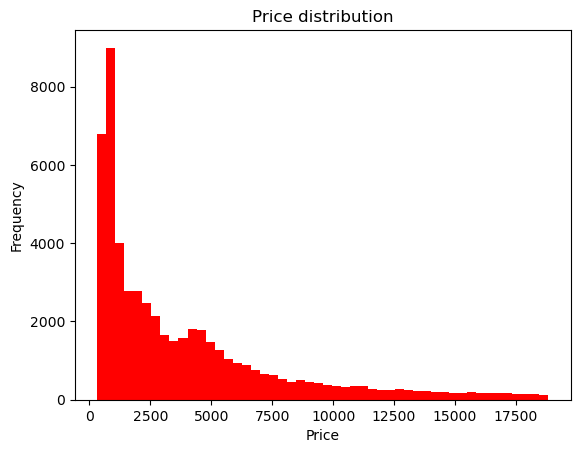

In [ ]:
# Plotting the istogram ofr the price distribition and saving it in the FIGURES directory

plt.figure()
plt.hist(df_small_carat["price"], bins = 50, color = "red")
plt.title("Price distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.savefig(FIGURES / "price_histogram.png", bbox_inches="tight")
plt.show()

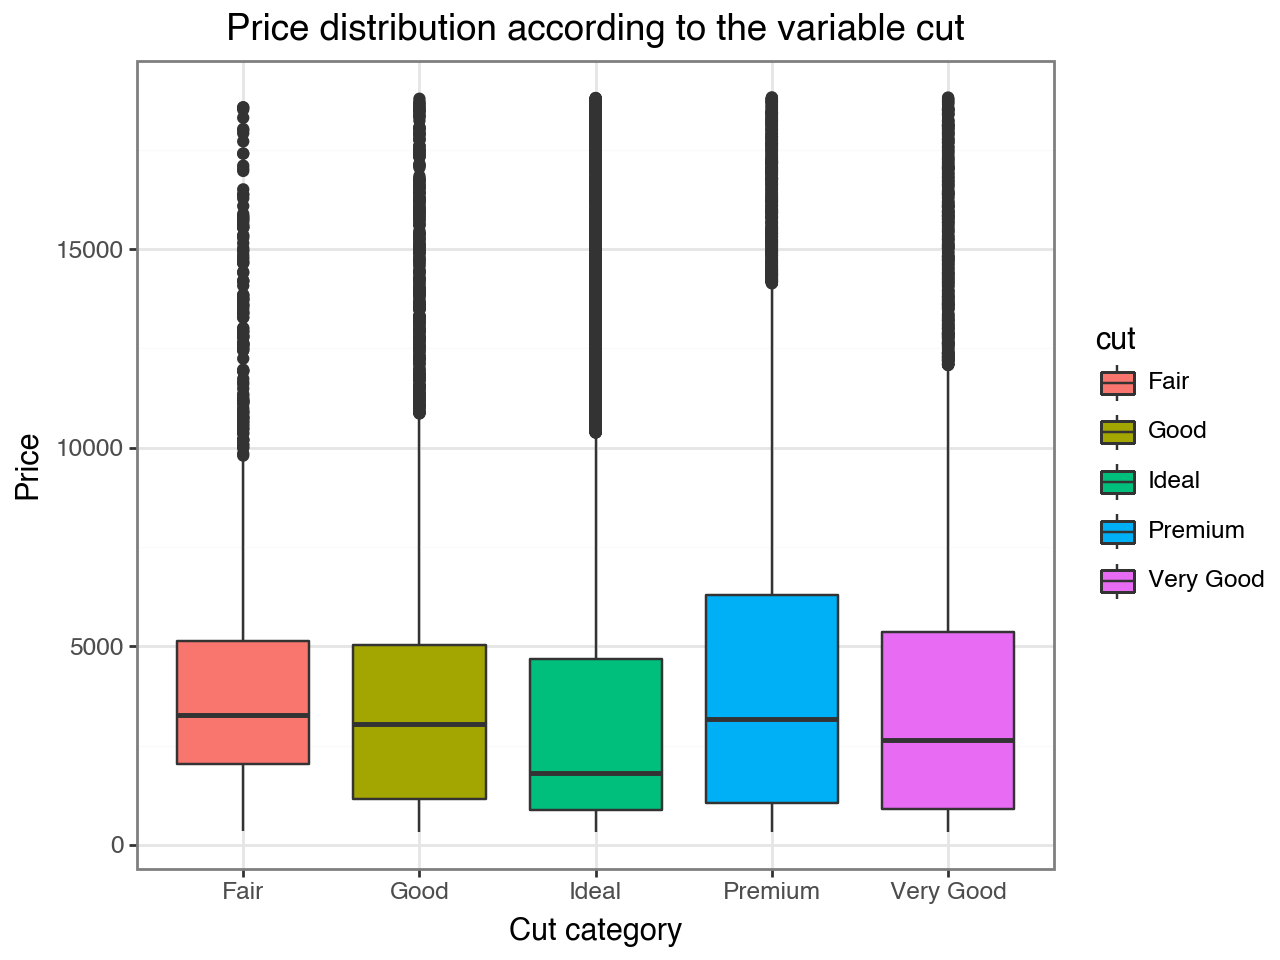

In [30]:
# Using ggplot to plot a box plot that represents the price distribution for each category of the variable cut

boxplot_1 = (
    ggplot(df_small_carat, aes(x="cut", y="price", fill="cut"))
    + geom_boxplot()
    + theme_bw()
    + labs(title = "Price distribution according to the variable cut", 
           x = "Cut category",
           y = "Price"
           )
)

# Saving the graph in the FIGURES directory

boxplot_1.save(FIGURES / "boxplot_price_cut.png", dpi = 120, verbose = False)

boxplot_1

# From the graph it can be said that the median of each category for the price tend to be equal to the other, with premium and very good that are slightly above the others. Each category for the price shows a lot of outliers and variability, but this could be normal as the price of the diamonds do not depend only from the number of carats but also from other variables

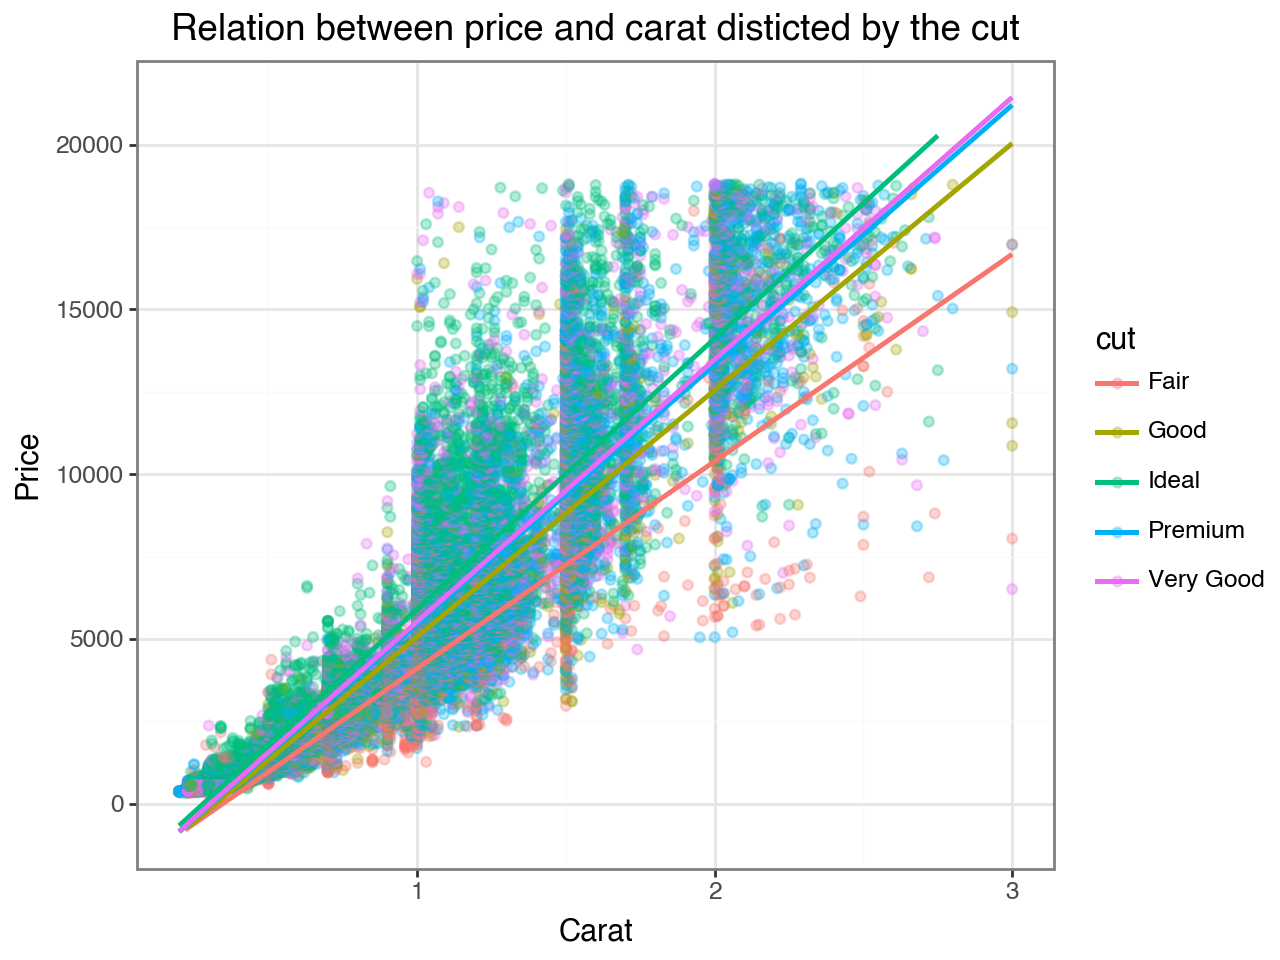

In [31]:
# Plotting teh relation between price and cut grouped by the categories of cut

regression_graph = (
    ggplot(df_small_carat, aes(x="carat", y="price", color="cut"))
    + geom_point(alpha = 0.3)
    + geom_smooth(method = "lm", se=False)
    + theme_bw()
    + labs(title = "Relation between price and carat disticted by the cut", 
           x = "Carat",
           y = "Price"
           )
)

# Saving the graph in the FIGURES directory

regression_graph.save(FIGURES / "regression_graph.png", dpi = 120, verbose = False)

regression_graph

# From the graph it can be said that each line has a positive slope and so the price increases as the carats increase. The relationship between the two is linear but with the diamonds with more carats that grows in the price more than proportionally. The lines are near to eachother but some differences that shouws that the price of the diamonds also depende by the quality of the cut. The graph is dense of points between 0.2 and 1.5 carats and the density diminishes as the carates increase, because diamonds of major dimentions are more rare. In conclusion there's a strong correlation between the price and the carats with little differences given by the quality of the cut.

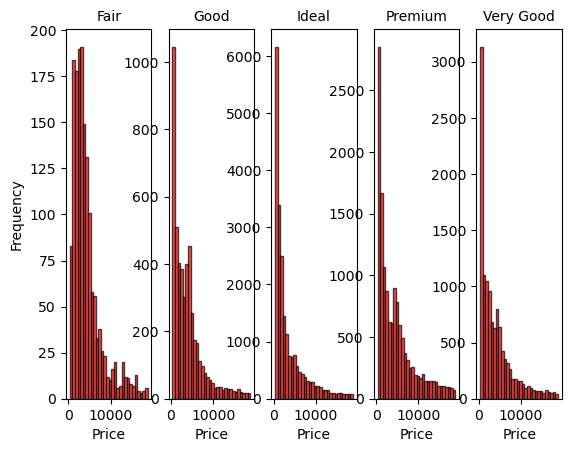

In [35]:
# Creation of different graphs, about the price distribution, with a for loop for each category of the variable cut 

# Sorting the category of cut

cuts = sorted(df_small_carat["cut"].dropna().unique())

# Creation of the figure through the object-oriented approach

fig, axes = plt.subplots(1, len(cuts))

# Creation of an histogram for each cut

for ax, i in zip(axes, cuts):
    values = df_small_carat.loc[df_small_carat["cut"] == i, "price"].dropna()
    ax.hist(values, bins=30, color="red", alpha=0.7, edgecolor="black")
    ax.set_title(f"{i}", fontsize=10)
    ax.set_xlabel("Price")
    if ax == axes[0]:
        ax.set_ylabel("Frequency")

plt.savefig(FIGURES/"four_histograms_for_cut.png", bbox_inches="tight") 
plt.show()

# The distribution of the price in each category of cut varies a lot, especially vor the cuts: Fair and and Good. This dempnstrate that the cut quality influences the price in a limited way, others variables as carat, color or the dimention of the diamond probabily influence more the price